In [2]:
import json 
import pandas as pd
with open('producthunt_posts_2019-01-01_to_2025-01-01.json') as f:
    data = json.load(f)
    

df = pd.DataFrame(data['posts'])

# Read in data

In [3]:
with open("data/clean/atus_roles.txt") as f:
    atus_roles = f.read().splitlines()
    
with open("data/clean/onet_roles.txt") as f:
    onet_roles = f.read().splitlines()
    
nouns = pd.read_json("data/clean/common_nouns.json")['nouns'].to_list()
print(nouns)
    
social_words = atus_roles + onet_roles + nouns

['conversation', 'feedback', 'support', 'guidance', 'mentorship', 'collaboration', 'interaction', 'communication', 'advice', 'trust', 'empathy', 'connection', 'networking', 'relationship', 'understanding', 'conflict', 'negotiation', 'bonding', 'listening', 'sharing']


In [1]:
print(df.columns)
# Index(['id', 'name', 'slug', 'tagline', 'description', 'url', 'website',
#        'votesCount', 'commentsCount', 'createdAt', 'featuredAt'],
#       dtype='object')

import re
def string_contains_word(s, word_list):
    """
    Regex-based version with word boundaries for more precise matching.
    Slightly slower but handles edge cases better.
    """
    # Sort by length (longest first) to match longer phrases before shorter ones
    sorted_terms = sorted(word_list, key=len, reverse=True)
    
    # Escape special regex characters and create pattern
    escaped_terms = [re.escape(term) for term in sorted_terms]
    pattern = r'\b(' + '|'.join(escaped_terms) + r')\b'
    
    return bool(re.search(pattern, s, re.IGNORECASE))  
    
ai_terms = ["artificial intelligence", "large language model", "llm", "chatbot", "gpt", "a.i.", "ai-powered", "chatgpt", "agent", "agentic", "generative ai", "ai assistant", "virtual assistant", "dialogue system", "voice assistant", "bot", "foundation model"]

social_words = atus_roles + onet_roles 

social_words = social_words.copy()
df['text'] = df['name'] + df["tagline"] + df["description"]
df = df.dropna(subset=['text'])
df['text'] = df['text'].apply(lambda x: x.lower())

df['ai'] = df['text'].apply(lambda x: string_contains_word(x, ai_terms))
df['social'] = df['text'].apply(lambda x: string_contains_word(x, social_words))



NameError: name 'df' is not defined

# Filter dataframe and create col

In [41]:
df = df.query("ai == True")
df['y'] = df['social'].astype(int)
df['dt'] = pd.to_datetime(df['createdAt'])
df = df.loc[df['dt'] < '2025-01-01']

In [42]:
df['y'].mean()

0.0243285051328927

# ML

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['y'], test_size=0.2, random_state=42)

# Perform GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'model__C': [0.01, 0.1, 1, 10]          # Regularization strength
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_pipeline = grid_search.best_estimator_

# Evaluate the best pipeline
y_pred = best_pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(best_pipeline, 'text_classification_pipeline.pkl')

loaded_pipeline = joblib.load('text_classification_pipeline.pkl')

# Predict on new data
new_texts = [
    "AI-powered chatbot for customer support.",
    "A mental health coach to help you achieve your goals."
]
predictions = loaded_pipeline.predict(new_texts)
print("Predictions:", predictions)

vectorizer = loaded_pipeline.named_steps['tfidf']
model = loaded_pipeline.named_steps['model']
feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_.flatten()

# Get top 10 positive and negative words
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

print("Top Positive Words:", feature_names[top_positive_indices])
print("Top Negative Words:", feature_names[top_negative_indices])

Best Parameters: {'model__C': 1, 'tfidf__ngram_range': (1, 1)}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1395
           1       1.00      0.64      0.78        28

    accuracy                           0.99      1423
   macro avg       1.00      0.82      0.89      1423
weighted avg       0.99      0.99      0.99      1423
Predictions: [0 1]
Top Positive Words: ['friend' 'coach' 'manager' 'employee' 'girlfriend' 'child' 'boss'
 'advisor' 'therapist' 'parents']
Top Negative Words: ['chatgpt' 'gpt' 'platform' 'text' 'llm' 'power' 'chatbots' 'language'
 'content' 'need']


In [44]:
new_texts = [
    "AI calculcator",
    "A mental health coach to help you achieve your goals."
]
predictions = loaded_pipeline.predict(new_texts)
print("Predictions:", predictions)

Predictions: [0 1]


In [45]:
df['yhat'] = loaded_pipeline.predict(df['text'].to_list())


In [46]:
df['agreed'] = (df['y'] == df['yhat'])*1

In [47]:
df['agreed'].mean()

0.9985937280270004

In [48]:
df

,id,name,slug,tagline,description,url,website,votesCount,commentsCount,createdAt,featuredAt,text,ai,social,y,dt,yhat,agreed,count_social
311,142396,TuSimple,tusimple,Autonomous trucking startup,"TuSimple - Founded in 2015, is an Artificial I...",https://www.producthunt.com/posts/tusimple?utm...,https://www.producthunt.com/r/ec1f90e72a82a1?u...,10,0,2019-01-07T11:38:45Z,None,tusimpleautonomous trucking startuptusimple - ...,True,False,0,2019-01-07 11:38:45+00:00,0,1,0
382,142474,Premier Badminton League Official Chatbot,premier-badminton-league-official-chatbot,Official Chatbot of PBL India season 4 by morp...,Premier Badminton League Official Chatbot is l...,https://www.producthunt.com/posts/premier-badm...,https://www.producthunt.com/r/a2a94a0a8a01d5?u...,11,4,2019-01-08T11:38:53Z,None,premier badminton league official chatbotoffic...,True,False,0,2019-01-08 11:38:53+00:00,0,1,0
912,143032,DeLaatBusiness,delaatbusiness,Over 60+ free tools for businesses/freelancers,"Free tools including SEO, keywords, webmaster,...",https://www.producthunt.com/posts/delaatbusine...,https://www.producthunt.com/r/dc2336835970a3?u...,3,0,2019-01-16T21:59:24Z,None,delaatbusinessover 60+ free tools for business...,True,False,0,2019-01-16 21:59:24+00:00,0,1,0
945,143106,Boredaf,boredaf-2,An app that tells you random s**t to do if you...,Boredaf is a chatbot can tell you a cool thing...,https://www.producthunt.com/posts/boredaf-2?ut...,https://www.producthunt.com/r/bd2e776567e80b?u...,303,12,2019-01-17T13:49:53Z,2019-01-17T13:49:53Z,boredafan app that tells you random s**t to do...,True,False,0,2019-01-17 13:49:53+00:00,0,1,0
1231,143366,Sava Events,sava-events-2,All-in-one event management platform for event...,Sava Events platform is all about reinventing ...,https://www.producthunt.com/posts/sava-events-...,https://www.producthunt.com/r/3011908bc8d7f9?u...,9,1,2019-01-22T14:03:01Z,None,sava eventsall-in-one event management platfor...,True,False,0,2019-01-22 14:03:01+00:00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210746,744294,CompareLLM,comparellm,Test outputs and performance of popular LLMs f...,Choose the best LLM for your prompt,https://www.producthunt.com/posts/comparellm?u...,https://www.producthunt.com/r/WS2KF62OI3575L?u...,2,1,2024-12-30T08:01:00Z,None,comparellmtest outputs and performance of popu...,True,False,0,2024-12-30 08:01:00+00:00,0,1,0
210814,744634,RadostLLM,radostllm,The sleek web ui for the Ollama LLM runner,"RadostLLM is a cutting-edge, web-based user in...",https://www.producthunt.com/posts/radostllm?ut...,https://www.producthunt.com/r/X5XSB4YBV6RLZD?u...,3,1,2024-12-31T08:01:00Z,None,radostllmthe sleek web ui for the ollama llm r...,True,False,0,2024-12-31 08:01:00+00:00,0,1,0
210823,740924,Chat GPT Prompt Master,chat-gpt-prompt-master,"Access over 15,000 ready-made AI prompts for C...","Key Features: 15,000+ AI Prompts: Categorized ...",https://www.producthunt.com/posts/chat-gpt-pro...,https://www.producthunt.com/r/DN5GH4K2B3LRL7?u...,3,1,2024-12-31T08:01:00Z,None,"chat gpt prompt masteraccess over 15,000 ready...",True,False,0,2024-12-31 08:01:00+00:00,0,1,0
210827,744634,RadostLLM,radostllm,The sleek web ui for the Ollama LLM runner,"RadostLLM is a cutting-edge, web-based user in...",https://www.producthunt.com/posts/radostllm?ut...,https://www.producthunt.com/r/X5XSB4YBV6RLZD?u...,3,1,2024-12-31T08:01:00Z,None,radostllmthe sleek web ui for the ollama llm r...,True,False,0,2024-12-31 08:01:00+00:00,0,1,0


In [49]:
# time series plot 

df['dt'] = pd.to_datetime(df['createdAt'])

In [50]:
def calculate_proportion_by_aggregation(df, date_column, target_column, how='mean'):
    """
    Calculate the proportion of the target column by different time aggregations.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the datetime column.
        target_column (str): The name of the target column (binary).

    Returns:
        dict: A dictionary containing proportions aggregated by day, week, month, and year.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    if how=="mean":
        aggregations = {
            'day': df.groupby(df[date_column].dt.date)[target_column].mean(),
            'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].mean(),
            'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].mean(),
            'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].mean()
        }
    elif how=="sum":
        aggregations = {
            'day': df.groupby(df[date_column].dt.date)[target_column].sum(),
            'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].sum(),
            'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].sum(),
            'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].sum()
        }

    return aggregations

# Example usage
proportions = calculate_proportion_by_aggregation(df, date_column='dt', target_column='yhat',how='sum')

# Access proportions by day, week, month, or year
byd = proportions['day']
byw = proportions['week']
bym = proportions['month']
byy = proportions['year']

/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_10995/4103645729.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'week': df.groupby(df[date_column].dt.to_period('W'))[target_column].sum(),
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_10995/4103645729.py:27: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'month': df.groupby(df[date_column].dt.to_period('M'))[target_column].sum(),
/var/folders/kj/8p_kqzx533b8vldhm5sdjfc00000gn/T/ipykernel_10995/4103645729.py:28: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  'year': df.groupby(df[date_column].dt.to_period('Y'))[target_column].sum()


<Axes: xlabel='dt'>

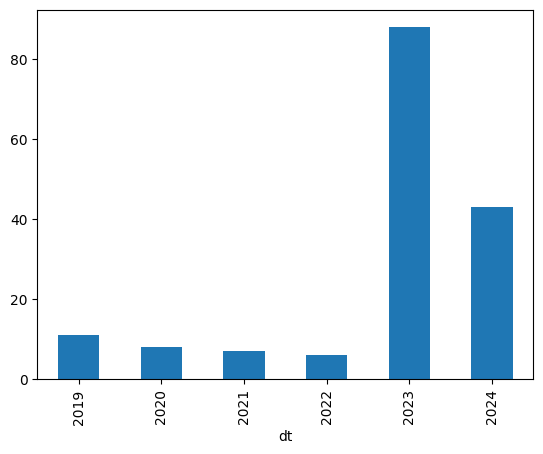

In [51]:
 byy.rolling(window=1, center=False).mean().plot(kind='bar')

<Axes: xlabel='dt'>

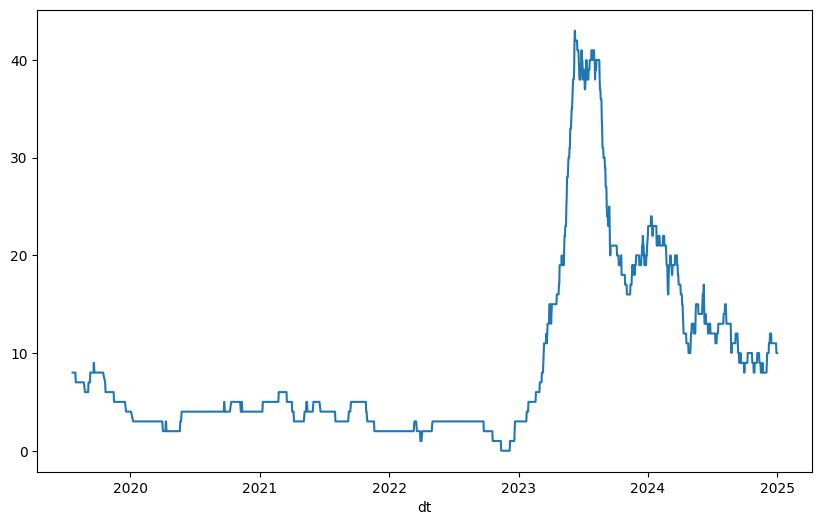

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
byd.rolling(window=100, center=False).sum().plot()

In [53]:
def string_count_words(s, word_list):
    """
    Regex-based version that counts occurrences of words/phrases in a string.
    Returns the total count of all matches found.
    
    Args:
        s (str): The string to search in
        word_list (list): List of words/phrases to search for
        
    Returns:
        int: Total count of all word matches found
    """
    # Sort by length (longest first) to match longer phrases before shorter ones
    sorted_terms = sorted(word_list, key=len, reverse=True)
    
    # Escape special regex characters and create pattern
    escaped_terms = [re.escape(term) for term in sorted_terms]
    pattern = r'\b(' + '|'.join(escaped_terms) + r')\b'
    
    # Find all matches and return count
    matches = re.findall(pattern, s, re.IGNORECASE)
    return len(matches)


df['count_social'] = df['text'].apply(lambda x: string_count_words(x, social_words))

In [54]:
def inspect_top_bottom(tdf, n=20):
    tdf = tdf.sort_values(by=['count_social'], ascending=False)
    top = tdf.head(n)
    bottom = tdf.tail(n)
    
    for t_tdf in [top, bottom]:
        for i, row in t_tdf.iterrows():
            print(f"Title: {row['name']}")
            print(f"Description: {row['description']}")
            print(f"Tagline: {row['tagline']}")
            print(f"Count: {row['count_social']}")
            print("-" * 50)
            
            
            
inspect_top_bottom(df, n=20)
        

Title: Friend Zone GPT
Description: Introducing Friend Zone GPT! Upload screenshots of your messages with your crush and find out if you're in the zone. Friend Zone GPT can.. 1. Evaluate if you're just his/her friend. 2. Provide logical reason to why. 3. Give you solution on how to improve!
Tagline: Find out if you're just a friend or not
Count: 5
--------------------------------------------------
Title: MyGirl—Your AI Girlfriend
Description: Mygirl is an AI girlfriend chatbot that provides users with a unique and interactive virtual girlfriend experience. Users can engage in non-filtered conversations with Mygirl, who is programmed to respond like a real girlfriend would.
Tagline: Not just an AI girlfriend chatbot, but your dream lover.
Count: 4
--------------------------------------------------
Title: Boss Hub
Description: Boss Hub Supports multiple forms, such as bar form, window form, full screen form. Boss Hub built-in 11+ Powerful AI, including GPT-4, ChatGPT, Microsoft Azure AI.